# Analyse Exploratoire H1 : Redéfinition de la Régularité

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import sys
import os

sns.set_theme(style="whitegrid")
%matplotlib inline

try:
    sys.path.append(os.path.abspath(os.path.join('..', 'src')))
    from data_loader import FitFamDataLoader
    print("Module data_loader importé avec succès.")
except ImportError:
    print("ERREUR : Le fichier data_loader.py n'est pas trouvé dans le dossier.")

loader = FitFamDataLoader()
unified_df = loader.get_unified_data()

unified_df['date'] = unified_df['start_time']
unified_df = unified_df.sort_values(['user_id', 'date'])

print("Données chargées.")
print(f"Total lignes : {len(unified_df)}")
print(f"Total utilisateurs : {unified_df['user_id'].nunique()}")
print(f"Période : du {unified_df['date'].min()} au {unified_df['date'].max()}")

Module data_loader importé avec succès.
Données chargées.
Total lignes : 405861
Total utilisateurs : 21304
Période : du 2018-08-07 06:00:00 au 2025-03-22 10:00:00


## 2. Feature Engineering de Base

In [2]:
# 1. Calcul de la "Date de début" pour chaque utilisateur
user_start = unified_df.groupby('user_id')['date'].min().reset_index()
user_start.columns = ['user_id', 'start_date']
df = unified_df.merge(user_start, on='user_id')

# Calcul de l'ancienneté (jours depuis le début)
df['days_since_start'] = (df['date'] - df['start_date']).dt.days

# 2. FILTRE COHORTE : On garde seulement les utilisateurs inscrits il y a > 90 jours
max_date = df['date'].max()
cutoff_date = max_date - timedelta(days=90)
valid_users = user_start[user_start['start_date'] <= cutoff_date]['user_id']
df_cohort = df[df['user_id'].isin(valid_users)].copy()

print(f"Utilisateurs analysables (>90 jours d'ancienneté) : {df_cohort['user_id'].nunique()}")

# 3. VARIABLES EXPLICATIVES (X) : Activité des 14 premiers jours
early_activity = df_cohort[df_cohort['days_since_start'] <= 14]

# Fréquence (Nombre de sessions total)
h1_data = early_activity.groupby('user_id').size().reset_index(name='frequency_14d')

# 4. VARIABLE CIBLE (Y) : Rétention
active_after_90d = df_cohort[df_cohort['days_since_start'] > 90]['user_id'].unique()
h1_data['is_retained_3m'] = h1_data['user_id'].isin(active_after_90d).astype(int)

print("Tableau de base prêt.")

Utilisateurs analysables (>90 jours d'ancienneté) : 21016
Tableau de base prêt.


## 3. Redéfinition des Métriques de Régularité

In [4]:
# Nouvelle définition de la régularité :
# 1. Régularité par type d'activité : Diversité des catégories (plus bas = plus spécialisé, donc "régulier" dans un type)
# Mesure : Nombre unique de catégories / nombre total de sessions (0 = toujours même catégorie, 1 = toutes différentes)

def calculate_category_diversity(x):
    if len(x) == 0:
        return np.nan
    unique_cats = x.nunique()
    total_sessions = len(x)
    return unique_cats / total_sessions  # Plus proche de 0 = plus régulier (spécialisé)

category_reg = early_activity.groupby('user_id')['category_name'].agg(calculate_category_diversity).reset_index(name='category_regularity_14d')

# 2. Régularité temporelle : Proportion de sessions en semaine vs weekend
# Mesure : Écart à la parité (0.5) - plus proche de 0 = équilibré semaine/weekend, donc "régulier"

def calculate_temporal_balance(x):
    if len(x) == 0:
        return np.nan
    weekday_count = x.dt.weekday.lt(5).sum()  # Lundi-Vendredi
    total = len(x)
    if total == 0:
        return np.nan
    weekday_prop = weekday_count / total
    return abs(weekday_prop - 0.5)  # Écart à 0.5 (équilibre parfait)

temporal_reg = early_activity.groupby('user_id')['date'].agg(calculate_temporal_balance).reset_index(name='temporal_regularity_14d')

# Fusionner avec h1_data
h1_data = h1_data.merge(category_reg, on='user_id', how='left')
h1_data = h1_data.merge(temporal_reg, on='user_id', how='left')

print("Nouvelles métriques de régularité calculées.")
display(h1_data.head())

Nouvelles métriques de régularité calculées.


,user_id,frequency_14d,is_retained_3m,category_regularity_14d,temporal_regularity_14d
0,1,10,0,0.200000,0.400000
1,2,3,1,0.333333,0.500000
2,3,5,1,0.400000,0.300000
3,4,7,1,0.142857,0.357143
4,5,6,1,0.166667,0.500000


## 4. Analyse de la Régularité par Type d'Activité

In [5]:
# Analyse de la diversité des catégories
print("Statistiques sur la régularité par catégorie :")
print(h1_data['category_regularity_14d'].describe())

# Comparaison par rétention
category_stats = h1_data.groupby('is_retained_3m')['category_regularity_14d'].mean()
print("\nMoyennes par groupe de rétention :")
print(category_stats)

Statistiques sur la régularité par catégorie :
count    21016.000000
mean         0.793006
std          0.290601
min          0.062500
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: category_regularity_14d, dtype: float64

Moyennes par groupe de rétention :
is_retained_3m
0    0.859206
1    0.667890
Name: category_regularity_14d, dtype: float64


## 5. Analyse de la Régularité Temporelle (Semaine vs Weekend)

In [6]:
# Analyse de l'équilibre semaine/weekend
print("Statistiques sur la régularité temporelle :")
print(h1_data['temporal_regularity_14d'].describe())

# Comparaison par rétention
temporal_stats = h1_data.groupby('is_retained_3m')['temporal_regularity_14d'].mean()
print("\nMoyennes par groupe de rétention :")
print(temporal_stats)

Statistiques sur la régularité temporelle :
count    21016.000000
mean         0.448464
std          0.132021
min          0.000000
25%          0.500000
50%          0.500000
75%          0.500000
max          0.500000
Name: temporal_regularity_14d, dtype: float64

Moyennes par groupe de rétention :
is_retained_3m
0    0.464013
1    0.419076
Name: temporal_regularity_14d, dtype: float64


## 6. Tests Statistiques sur les Nouvelles Métriques

In [7]:
from scipy.stats import mannwhitneyu

# Test pour la régularité par catégorie (diversité)
valid_cat = h1_data.dropna(subset=['category_regularity_14d'])
group_retained_cat = valid_cat[valid_cat['is_retained_3m'] == 1]['category_regularity_14d']
group_churned_cat = valid_cat[valid_cat['is_retained_3m'] == 0]['category_regularity_14d']

stat, p_value_cat = mannwhitneyu(group_retained_cat, group_churned_cat, alternative='two-sided')

print("Test sur la régularité par catégorie (diversité) :")
print(f"P-value = {p_value_cat:.5f}")
if p_value_cat < 0.05:
    print("-> RÉSULTAT SIGNIFICATIF")
else:
    print("-> Résultat non significatif")

# Test pour la régularité temporelle
valid_temp = h1_data.dropna(subset=['temporal_regularity_14d'])
group_retained_temp = valid_temp[valid_temp['is_retained_3m'] == 1]['temporal_regularity_14d']
group_churned_temp = valid_temp[valid_temp['is_retained_3m'] == 0]['temporal_regularity_14d']

stat, p_value_temp = mannwhitneyu(group_retained_temp, group_churned_temp, alternative='two-sided')

print("\nTest sur la régularité temporelle :")
print(f"P-value = {p_value_temp:.5f}")
if p_value_temp < 0.05:
    print("-> RÉSULTAT SIGNIFICATIF")
else:
    print("-> Résultat non significatif")

Test sur la régularité par catégorie (diversité) :
P-value = 0.00000
-> RÉSULTAT SIGNIFICATIF

Test sur la régularité temporelle :
P-value = 0.00000
-> RÉSULTAT SIGNIFICATIF


## 7. Visualisations des Résultats

C:\Users\gaspa\AppData\Local\Temp\ipykernel_4980\285794719.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_retained_3m', y='category_regularity_14d', data=h1_data, palette="Set2")
C:\Users\gaspa\AppData\Local\Temp\ipykernel_4980\285794719.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_retained_3m', y='temporal_regularity_14d', data=h1_data, palette="Set2")


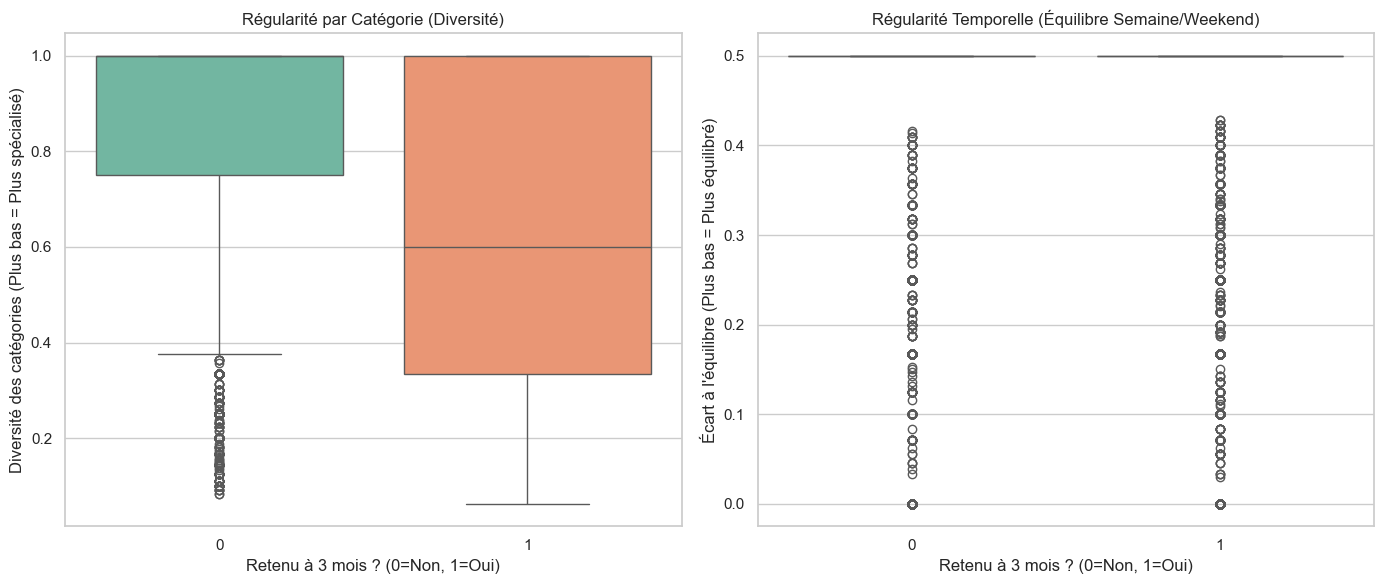

--- RÉSULTATS MOYENS NOUVELLES MÉTRIQUES ---


,category_regularity_14d,temporal_regularity_14d
is_retained_3m,,
0,0.859206,0.464013
1,0.667890,0.419076


In [10]:
plt.figure(figsize=(14, 6))

# Boxplot Régularité par catégorie
plt.subplot(1, 2, 1)
sns.boxplot(x='is_retained_3m', y='category_regularity_14d', data=h1_data, palette="Set2")
plt.title("Régularité par Catégorie (Diversité)")
plt.xlabel("Retenu à 3 mois ? (0=Non, 1=Oui)")
plt.ylabel("Diversité des catégories (Plus bas = Plus spécialisé)")

# Boxplot Régularité temporelle
plt.subplot(1, 2, 2)
sns.boxplot(x='is_retained_3m', y='temporal_regularity_14d', data=h1_data, palette="Set2")
plt.title("Régularité Temporelle (Équilibre Semaine/Weekend)")
plt.xlabel("Retenu à 3 mois ? (0=Non, 1=Oui)")
plt.ylabel("Écart à l'équilibre (Plus bas = Plus équilibré)")

plt.tight_layout()
plt.show()

# Moyennes
new_stats = h1_data.groupby('is_retained_3m')[['category_regularity_14d', 'temporal_regularity_14d']].mean()
print("--- RÉSULTATS MOYENS NOUVELLES MÉTRIQUES ---")
display(new_stats)

## 8. Sauvegarde des Résultats

In [9]:
# Sauvegarder les résultats dans un fichier CSV séparé
h1_data.to_csv('h1_exploratory_results.csv', index=False)
print("Résultats sauvegardés dans h1_exploratory_results.csv")

Résultats sauvegardés dans h1_exploratory_results.csv
